In [31]:
import os
import time
import pickle
import copy
import collections
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch
import itertools
from torch.autograd import Variable
import sklearn, sklearn.model_selection, sklearn.metrics
import numpy as np

from models.models import MLP, GCN, SLR
from data import datasets
from data.gene_graphs import GeneManiaGraph
from data.utils import record_result



In [3]:
dataset = datasets.TCGADataset()
dataset.df = dataset.df - dataset.df.mean(axis=0)

Torrent name: TCGA_tissue_ppi.hdf5, Size: 1748.32MB
Checking for pieces on disk: |██████████████████████████████████████████████████| 100.0% 
Found 1668 finished pieces out of 1668 total pieces.
Found dataset at /home/martin/.academictorrents-datastore/TCGA_tissue_ppi.hdf5
Converting one-hot labels to integers


In [4]:
# Setup the results dictionary
filename = "experiments/results/ubc-investigation-results.pkl"
try:
    results = pickle.load(open(filename, "rb"), encoding='latin1')
    print("Loaded Checkpointed Results")
except Exception as e:
    results = pd.DataFrame(columns=['auc', 'gene', 'model', 'with_UBC', 'seed', 'train_size', 'time_elapsed'])
    print("Created a New Results Dictionary")


Created a New Results Dictionary


In [5]:
gene_graph = GeneManiaGraph()

Torrent name: genemania.pkl, Size: 9.61MB


In [6]:
def get_every_n(a, n=2):
    for i in range(a.shape[0] // 2):
        yield a[2*i:2*(i+1)]

def bucket_weights(adj, bins):
    labels = ["".join(str(labels[0]) + "-" + str(round(labels[1], 1))) for labels in zip(bins, bins + 0.1)]
    labels[0] = "(" + labels[0]

    results = []
    nodes = {}
    for x in bins:
        subgraph = ((adj > x) & (adj <= x + 0.1))  
        results.append(subgraph.sum())
        nodes[x] = subgraph
    return results, labels, nodes


def show_degree(G):  
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    # print "Degree sequence", degree_sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    # draw graph in inset
    plt.axes([0.4, 0.4, 0.5, 0.5])
    Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
    pos = nx.spring_layout(G)
    plt.axis('off')
    nx.draw_networkx_nodes(G, pos, node_size=20)
    nx.draw_networkx_edges(G, pos, alpha=0.4)

    plt.show()


In [7]:
gene="RPL3"

In [8]:
first_degree_neighbors = ""
for gene in gene_graph.nx_graph.nodes:
    first_degree_neighbors = set([n for n in gene_graph.nx_graph.neighbors(gene)])
    if len(list(first_degree_neighbors)) > 20 and len(list(first_degree_neighbors)) < 50:
        break
second_degree_neighbors = first_degree_neighbors.copy()
for gene in first_degree_neighbors:
    for second_gene in gene_graph.nx_graph.neighbors(gene):
        second_degree_neighbors.add(second_gene)
nx_graph = gene_graph.nx_graph.subgraph(second_degree_neighbors)

In [9]:
nx_graph

In [10]:
adj = np.asarray(nx.to_numpy_matrix(nx_graph))

In [11]:
bins = np.array([round(x, 1) for x in np.arange(0., 1., 0.1)])
rpl_results, rpl_labels, nodes = bucket_weights(adj, bins)

/media/martin/the_milano/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


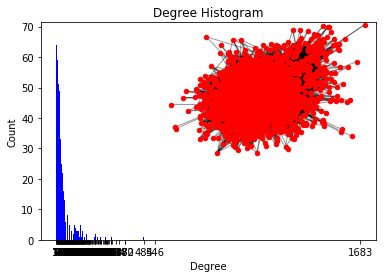

In [12]:
show_degree(nx_graph)

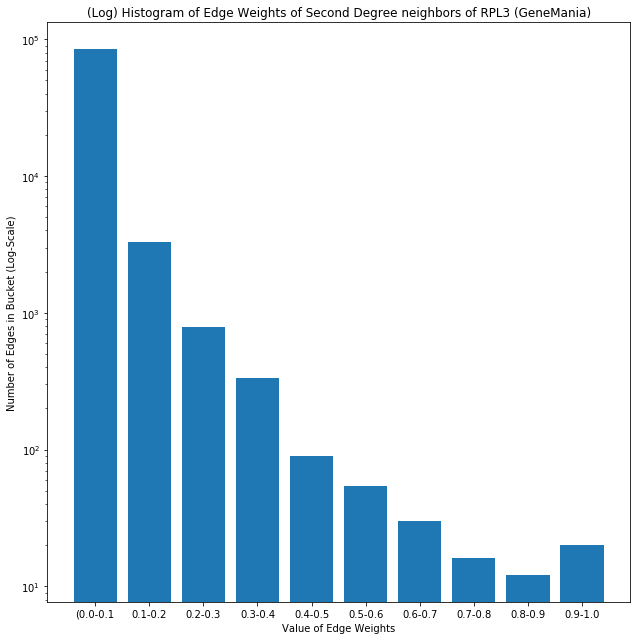

In [13]:
plt.figure(figsize=(9, 9))

plt.bar(x=rpl_labels, height=rpl_results, log=1)
plt.title("(Log) Histogram of Edge Weights of Second Degree neighbors of RPL3 (GeneMania)")
plt.xlabel("Value of Edge Weights")
plt.ylabel("Number of Edges in Bucket (Log-Scale)")
plt.xlim=1.0

plt.tight_layout()
plt.show()

In [14]:
gene = ""
genes = []
for node in nx_graph:
    if len(list(nx_graph.neighbors(node))) == 1683:
        genes = list(nx_graph.neighbors(node))
        gene = node

In [15]:
ubc_nx_graph = nx.Graph()
for node1, node2, edge in nx_graph.edges("UBC", data="weight"):
    ubc_nx_graph.add_node(node1)
    ubc_nx_graph.add_node(node2)
    ubc_nx_graph.add_edge(node1, node2, weight=edge)
ubc_adj = np.asarray(nx.to_numpy_matrix(ubc_nx_graph))


In [16]:
ubc_adj.max()
def bucket_weights_ubc(adj, bins):
    labels = ["".join(str(labels[0]) + "-" + str(round(labels[1], 3))) for labels in zip(bins, bins + 0.005)]
    labels[0] = "(" + labels[0]

    results = []
    nodes = {}
    for x in bins:
        subgraph = ((adj > x) & (adj <= x + 0.1))  
        results.append(subgraph.sum())
        nodes[x] = subgraph
    return results, labels, nodes

In [17]:
bins = np.array([round(x, 3) for x in np.arange(0., .043, 0.004)])
ubc_results, ubc_labels, nodes = bucket_weights_ubc(ubc_adj[::2], bins)

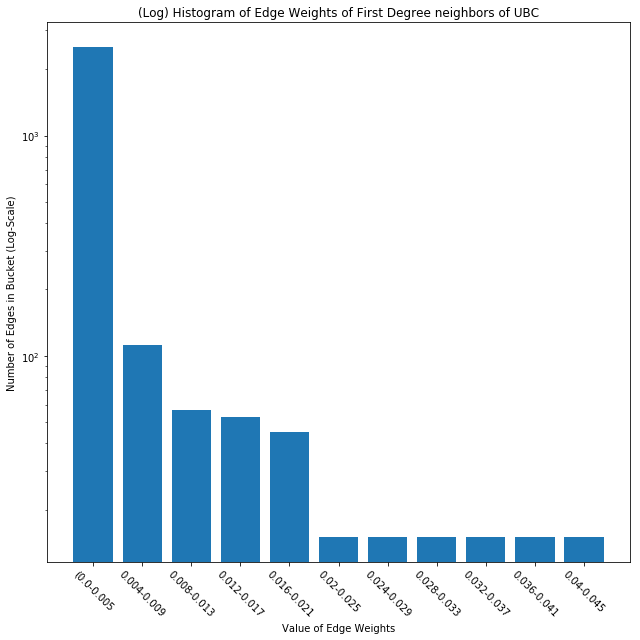

In [18]:
plt.figure(figsize=(9, 9))

plt.bar(x=ubc_labels, height=ubc_results, log=1)
plt.title("(Log) Histogram of Edge Weights of First Degree neighbors of UBC")
plt.xlabel("Value of Edge Weights")
plt.ylabel("Number of Edges in Bucket (Log-Scale)")
plt.xlim=1.0
plt.xticks(rotation=-45)

plt.tight_layout()
plt.show()

In [35]:
train_size = 50
test_size = 1000
trials = 3
cuda = True
models = [
              GCN(name="GCN_lay20_chan32_emb32_dropout_pool_hierarchy", dropout=True, cuda=cuda, num_layer=4, channels=32, embedding=32, prepool_extralayers=5, pooling="hierarchy"),
              GCN(name="GCN_lay20_chan32_emb32_dropout_pool_random", dropout=True,cuda=cuda, num_layer=4, channels=32, embedding=32, prepool_extralayers=5, pooling="random"),
              MLP(name="MLP_lay2_chan512_dropout", cuda=cuda, dropout=True, num_layer=2, channels=512),
              MLP(name="MLP_lay2_chan512", cuda=cuda, dropout=False, num_layer=2, channels=512),
              SLR(name="SLR_lambda1_l11", cuda=cuda)
]

In [36]:
results["with_UBC"] = None

In [37]:
# Create the set of all experiment ids and see which are left to do
columns = ["gene", "model", "with_UBC", "train_size", "seed"]
all_exp_ids = [x for x in itertools.product(["RPL3"],  [model.name for model in models], [True, False], [50], range(trials))]
all_exp_ids = pd.DataFrame(all_exp_ids, columns=columns)
all_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in all_exp_ids.itertuples(name=None)]
results_exp_ids = results[columns].copy()
results_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in results_exp_ids.itertuples(name=None)]
intersection_ids = all_exp_ids.index.intersection(results_exp_ids.index)
todo = all_exp_ids.drop(intersection_ids).to_dict(orient="records")
print("todo: " + str(len(todo)))
print("done: " + str(len(results)))

todo: 30
done: 1


In [43]:
for row in todo:
    print(row["seed"])
    start_time = time.time()
    gene = row["gene"]
    seed = row["seed"]
    with_UBC = row["with_UBC"]
    train_size = row["train_size"]
    model = [copy.deepcopy(model) for model in models if model.name == row["model"]][0]

    experiment = {
        "gene": gene,
        "model": model.name,
        "with_UBC": with_UBC,
        "train_size": train_size,
        "seed": seed,
    }

    dataset.labels = dataset.df[gene].where(dataset.df[gene] > 0).notnull().astype("int")
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)
    
    
    if with_UBC:
        ubc_adj = np.zeros(np.asarray(nx.to_numpy_matrix(ubc_nx_graph)).shape)
        zeros = np.asarray(nx.to_numpy_matrix(nx_graph))
        zeros[0: ubc_adj.shape[0], 0: ubc_adj.shape[1]] += ubc_adj
        adj = zeros
    else:
        adj = np.asarray(nx.to_numpy_matrix(nx_graph))
    
    X_train = X_train[list(nx_graph.nodes)].copy()
    X_test = X_test[list(nx_graph.nodes)].copy()
    X_train[gene] = 1
    X_test[gene] = 1
    
    model.fit(X_train, y_train, adj=adj)
    
    x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()
    if cuda:
        x_test = x_test.cuda()
    
    y_hat = []
    for chunk in get_every_n(x_test, 10):
        y_hat.extend(model.predict(chunk)[:,1].data.cpu().numpy().tolist())
    auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())

    del model
    experiment["auc"] = auc
    experiment["time_elapsed"] = str(time.time() - start_time)
    experiment["cuda"] = cuda
    results = record_result(results, experiment, filename)
    print("time elapsed for exp: " + str(time.time() - start_time))


0
setup layers took: 0.07322549819946289
epoch: 0 0.18403220176696777
epoch: 1 0.17931652069091797
epoch: 2 0.17673683166503906
epoch: 3 0.17789220809936523
epoch: 4 0.176727294921875
epoch: 5 0.17868638038635254
epoch: 6 0.17861604690551758
epoch: 7 0.1767899990081787
epoch: 8 0.1772441864013672
epoch: 9 0.17859315872192383
epoch: 10 0.17790889739990234
epoch: 11 0.17803096771240234
epoch: 12 0.1778733730316162
epoch: 13 0.17749261856079102
epoch: 14 0.17793989181518555
epoch: 15 0.17761898040771484
total train time:9.002447128295898 for epochs: 16
time elapsed for exp: 25.19628620147705
1
setup layers took: 0.07070589065551758
epoch: 0 0.18135499954223633
epoch: 1 0.1797802448272705
epoch: 2 0.18243193626403809
epoch: 3 0.17847776412963867
epoch: 4 0.1791222095489502
epoch: 5 0.17920422554016113
epoch: 6 0.1973419189453125
epoch: 7 0.1798698902130127
epoch: 8 0.18002772331237793
epoch: 9 0.1818547248840332
epoch: 10 0.18237018585205078
epoch: 11 0.18722820281982422
epoch: 12 0.193592

NameError: name 'gene_graph' is not defined

(0.65, 0.85)

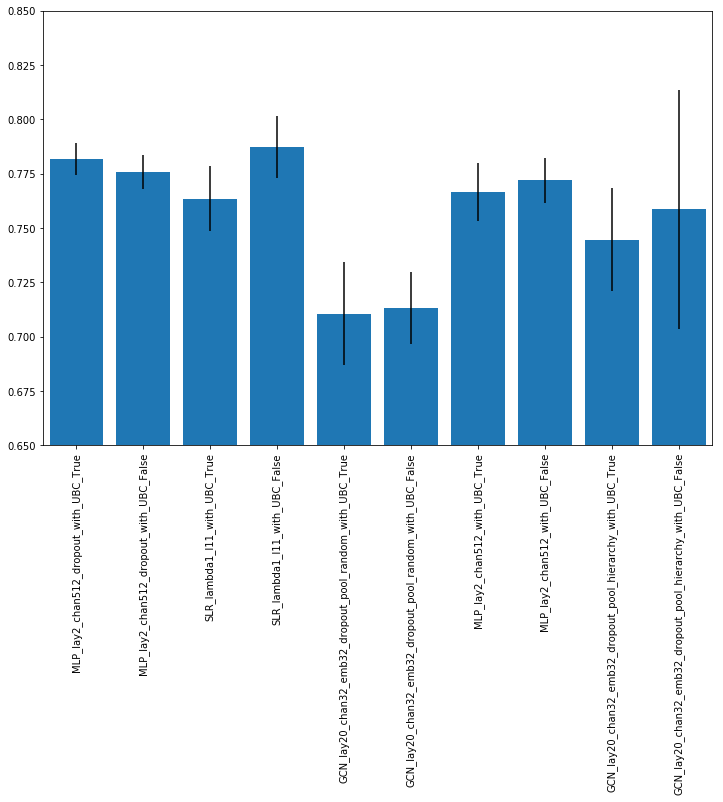

In [72]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.5, 3.6)
plot_train_size = 50

subset = results[(results.train_size==50) & 
                  (results.model != "GCN_lay3_chan64_emb32")]


q = subset.groupby(['model', 'with_UBC'])['auc']

stderr = []
mean = []
labels = []
for model, with_UBC in itertools.product(set(subset.model), [True, False]):
    labels.append(model + "_with_UBC_" + str(with_UBC))
    mean.append(q.mean()[model][with_UBC])
    stderr.append(q.std()[model][with_UBC]/np.sqrt(q.count()[model][with_UBC]))

freq_series = pd.Series.from_array(mean)

plt.figure(figsize=(12, 8))
fig = freq_series.plot(kind='bar')

plt.bar(x=range(2 * len(set(subset.model))), height=mean, yerr=stderr)
fig.set_xticklabels(labels)
fig.set_ylim((0.65, 0.85))

In [29]:
regnet = RegNetGraph()

Torrent name: regnet.pkl, Size: 8.81MB


In [30]:
nodes, one_gene_adj = regnet.first_degree("RPL3")
print("num_edges: " + str((one_gene_adj>0.).sum()/2))

num_edges: 1007.0


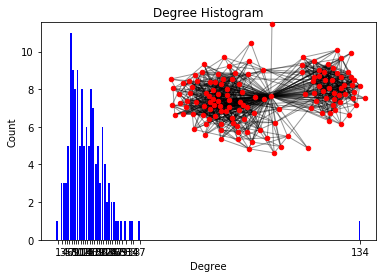

In [31]:
G = nx.from_numpy_matrix(np.matrix(one_gene_adj))
show_degree(G)

In [32]:
temp = np.array(nx.to_numpy_matrix(regnet.nx_graph))/np.array(nx.to_numpy_matrix(regnet.nx_graph)).max()
bins = np.array([round(x, 1) for x in np.arange(0., 1., 0.1)])
regnet_results, regnet_labels, nodes = bucket_weights(temp, bins)

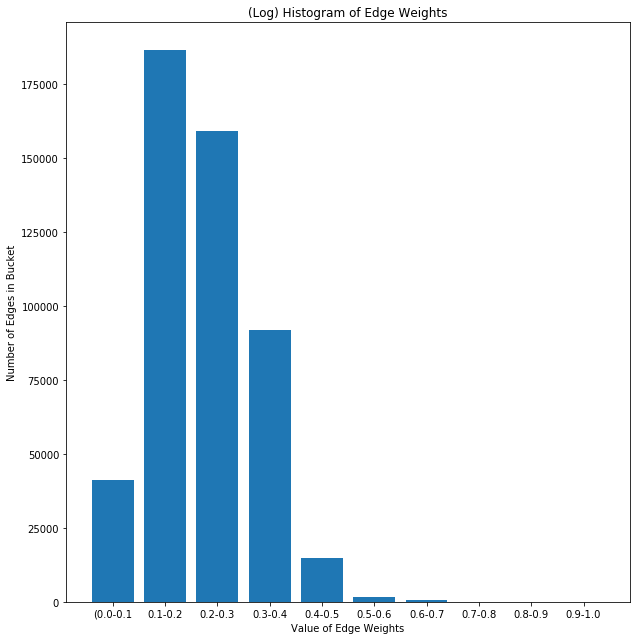

In [33]:
plt.figure(figsize=(9, 9))

plt.bar(x=regnet_labels, height=regnet_results)
plt.title("(Log) Histogram of Edge Weights")
plt.xlabel("Value of Edge Weights")
plt.ylabel("Number of Edges in Bucket")
plt.xlim=1.0

plt.tight_layout()
plt.show()

/media/martin/the_milano/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Clustered by SKLearn Agglomerative Clustering


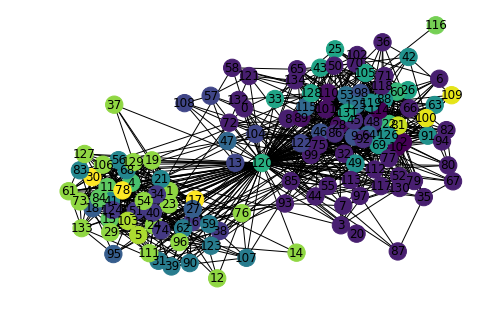

In [34]:
clusters = AgglomerativeClustering(n_clusters=25, affinity='euclidean', memory='/tmp', connectivity=one_gene_adj, compute_full_tree='auto', linkage='ward').fit_predict(one_gene_adj)
G = nx.from_numpy_matrix(np.matrix(one_gene_adj)) 
nx.draw(G, node_color=clusters, with_labels=True)
print("Clustered by SKLearn Agglomerative Clustering")


(array([20., 12.,  4.,  4.,  5.,  4.,  1.,  0.,  0.,  1.]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <a list of 10 Patch objects>)

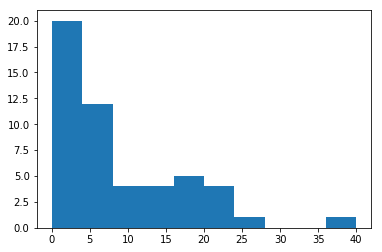

In [35]:
plt.hist(np.hstack(np.histogram(clusters, bins=len(set(clusters)))))

In [36]:
new_clusters = []
biggest_cluster = np.argmax(np.bincount(clusters))
for i, cluster in enumerate(clusters):
    if cluster != biggest_cluster:
        new_clusters.append(i)


In [1]:
nodes, one_gene_adj = regnet.first_degree("RPL3")
print("num_edges: " + str((one_gene_adj>0.).sum()/2))

NameError: name 'regnet' is not defined

In [25]:
np.max(one_gene_adj[16], axis=0)

0.024000000208616257

In [29]:
np.set_printoptions(threshold=np.nan)


In [32]:
one_gene_adj.shape

(135, 135)

In [73]:
num_genes = np.histogram(one_gene_adj.max(axis=1))[0]
edge_weight =  np.histogram(one_gene_adj.max(axis=1))[1]

([<matplotlib.axis.XTick at 0x10bd3e358>,
 <a list of 10 Text xticklabel objects>)

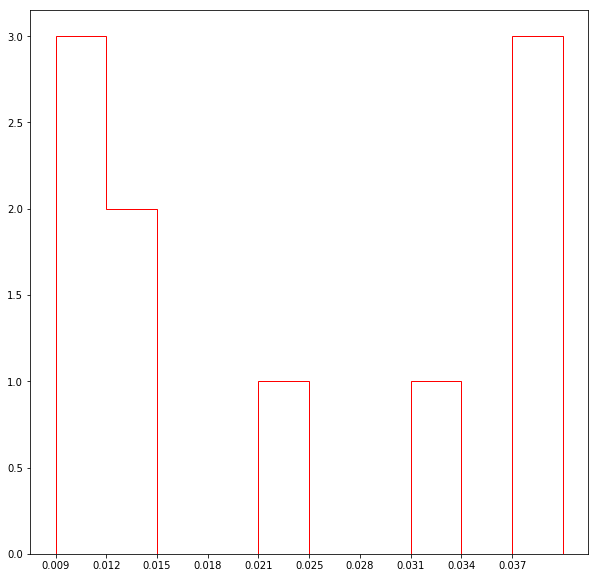

In [110]:
plt.figure(figsize=(10,10))
plt.hist(num_genes, bins=10, range=[0, 30], histtype='step',edgecolor='r')
plt.xticks(range(0, 30, 3), [round(x,3) for x in edge_weight])


<BarContainer object of 10 artists>

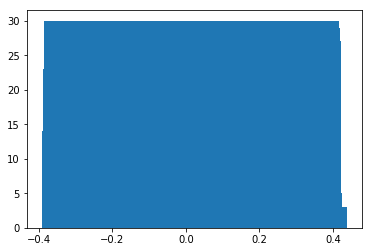

In [85]:
plt.bar(x=edge_weight[:10], height=num_genes)

ValueError: 'c' argument has 7220 elements, which is not acceptable for use with 'x' with size 135, 'y' with size 135.

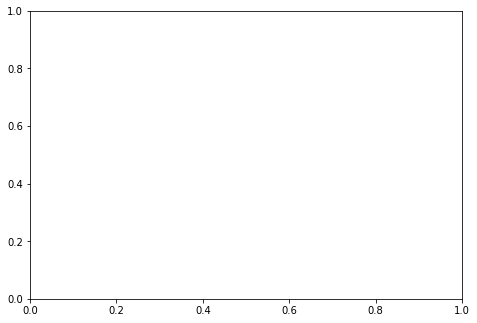

In [27]:
max_edge_weight = {}
i=0
for b in bins:
    for node1, node2 in np.argwhere(nodes[b]):
        max_edge_weight[node1] = int(10 * b)
        max_edge_weight[node2] = int(10 * b)
edge_colors = list((np.round(one_gene_adj[one_gene_adj.nonzero()].flatten(), 1) * 10).astype(int))[::2]
nx.draw(G, node_color=list(max_edge_weight.values()), edge_color=edge_colors, with_labels=True)
print("Clustered by max edge weight")


# Make the chart
bins = np.array([round(x, 1) for x in np.arange(0., 1., 0.1)])
one_gene_results, one_gene_labels, nodes = bucket_weights(one_gene_adj, bins)
plt.figure(figsize=(9, 9))
plt.bar(x=one_gene_labels, height=one_gene_results)
plt.title("Histogram of Edge Weights for a BFS Resulting in 50 genes near TERT")
plt.xlabel("Value of Edge Weight")
plt.ylabel("Number of Edges in Bucket")
plt.xticks(bins*10, labels=one_gene_labels[1:])
plt.show()